# Weather Derivatives Pricing

## Goal and Method

<b>Aim</b>: calculate the fair value of a temperature option to compare with the market

Average temperature: $\large T_n = \frac{T^{max}+T^{min}}{2}$

Heating and Cooling Degree Days (for a given day $n$):
- $ HDD_n = (T_{ref}-T_n)^+$
- $CDD_n = (T_n - T_{ref})^+$

<b>Option Payoff</b>: a function of relevant (heating or cooling) degree days over a set period (compared to strike price)

## Sourcing and Cleaning Temperature Data

### Dataset

Source: Open-Meteo Weather API archive
Location: New York City, USA
Period: 1950 to 2023

In [125]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math

from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults

from scipy.integrate import quad
from scipy.stats import norm
from scipy import interpolate, stats
from scipy.optimize import curve_fit

In [126]:
# !pip install openmeteo-requests
# !pip install requests-cache retry-requests numpy pandas
# !pip install statsmodels --upgrade

### Source data

In [127]:
startdate="1950-01-01"
enddate="2023-11-01"

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.73061,
	"longitude": -73.935242,
	"start_date": startdate,
	"end_date": enddate,
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

daily_df = pd.DataFrame(data = daily_data)

Coordinates 40.738136291503906°E -73.91488647460938°N
Elevation 14.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


### Data cleaning

In [128]:
temperatures=daily_df
temperatures['date']=pd.date_range(start=startdate, end=enddate)
temperatures.rename(columns={'date': "Date", 'temperature_2m_max': "Tmax",'temperature_2m_min':"Tmin", 'temperature_2m_mean':"T"},inplace=True)
temperatures.set_index('Date', inplace=True)

# Indicate winter and summer periods
# NYC: Winter ~ May-Oct Summer ~ Nov-Apr
temps_season = temperatures.copy(deep=True)
temps_season['month'] = temps_season.index.month
mask = (temps_season['month'] >= 5) & (temps_season['month'] <= 10)
temps_season['winter'] = np.where(mask,1,0)
temps_season['summer'] = np.where(temps_season['winter'] != 1,1,0)
temps_season

,Tmax,Tmin,T,month,winter,summer
Date,,,,,,
1950-01-01,5.861000,-2.589000,0.981833,1,0,1
1950-01-02,9.111000,0.511000,4.679750,1,0,1
1950-01-03,13.861000,7.111000,10.221416,1,0,1
1950-01-04,18.261000,12.011001,14.419333,1,0,1
1950-01-05,15.211000,8.811001,12.688085,1,0,1
...,...,...,...,...,...,...
2023-10-28,26.917501,16.117500,20.346666,10,1,0
2023-10-29,16.167501,11.417500,12.846667,10,1,0
2023-10-30,19.367500,10.267500,14.090415,10,1,0


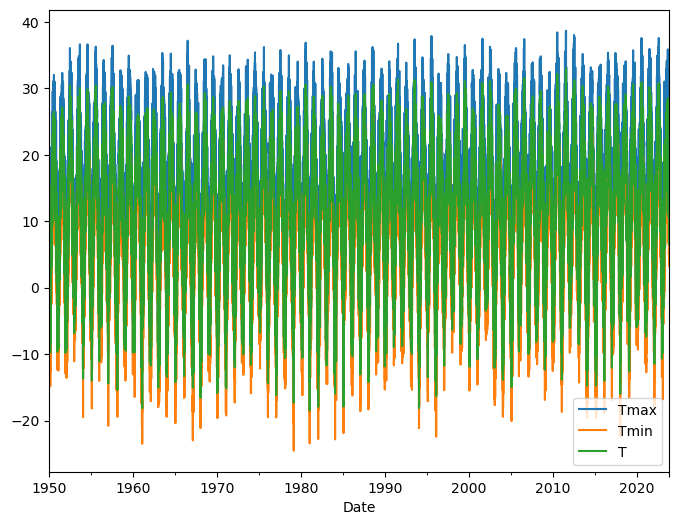

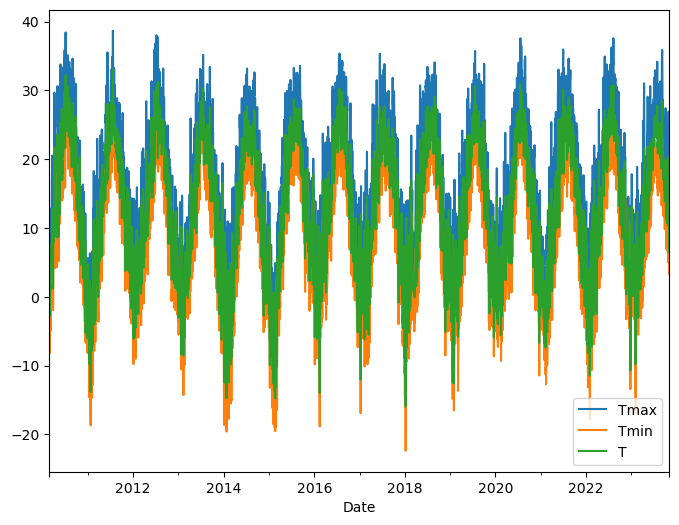

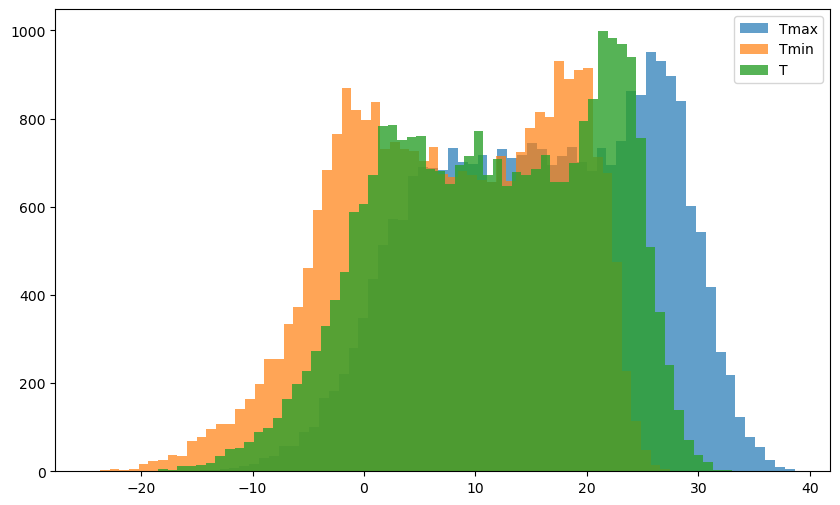

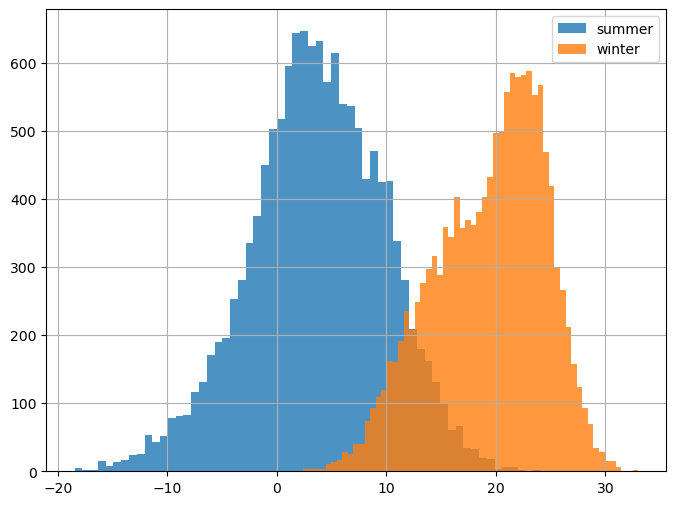

In [129]:
temperatures[:].plot(figsize=(8,6))
plt.show()

temperatures[-5000:].plot(figsize=(8,6))
plt.show()

plt.figure(figsize=(10,6))
temperatures.Tmax.hist(bins=60, alpha=0.7, label='Tmax')
temperatures.Tmin.hist(bins=60, alpha=0.7, label='Tmin')
temperatures['T'].hist(bins=60, alpha=0.8, label='T')
plt.grid(False)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
temps_season[temps_season['summer'] == 1]['T'].hist(bins=60, alpha=0.8, label='summer')
temps_season[temps_season['winter'] == 1]['T'].hist(bins=60, alpha=0.8, label='winter')
plt.legend()
plt.show()

In [130]:
# Temperature Records
# Compile list of min and max records for each month on record.
date_list = temperatures.index.tolist()
mth_temps = pd.DataFrame(data=date_list, index=date_list).resample('MS')[0].agg([min, max])
mth_temps['month'] = mth_temps.index.month
def min_max_temps(row):
    stats = temperatures[(temperatures.index >= row['min']) & (temperatures.index <= row['max'])].agg([min, max])
    row['Tmax_max'] = stats.loc['max', 'Tmax']
    row['Tmax_min'] = stats.loc['min', 'Tmax']
    row['Tmin_max'] = stats.loc['max', 'Tmin']
    row['Tmin_min'] = stats.loc['min', 'Tmin']
    row['T_max'] = stats.loc['max', 'T']
    row['T_min'] = stats.loc['min', 'T']
    return row

mth_temps = mth_temps.apply(min_max_temps,axis=1)
mth_temps

,min,max,month,Tmax_max,Tmax_min,Tmin_max,Tmin_min,T_max,T_min
1950-01-01,1950-01-01,1950-01-31,1,20.061001,-0.339000,12.011001,-7.1390,14.948502,-4.176500
1950-02-01,1950-02-01,1950-02-28,2,10.011001,-4.389000,1.911000,-14.8390,6.736000,-9.782749
1950-03-01,1950-03-01,1950-03-31,3,17.511000,-3.939000,12.361000,-12.5890,14.806834,-8.405665
1950-04-01,1950-04-01,1950-04-30,4,21.161001,7.361000,11.261001,-2.3390,15.283917,3.077667
1950-05-01,1950-05-01,1950-05-31,5,26.411001,10.311001,14.061001,4.2610,18.542250,8.583918
...,...,...,...,...,...,...,...,...,...
2023-07-01,2023-07-01,2023-07-31,7,34.167500,25.867500,22.817501,15.7675,27.794579,21.777916
2023-08-01,2023-08-01,2023-08-31,8,31.267500,23.817501,22.267500,14.7175,25.279999,20.205000
2023-09-01,2023-09-01,2023-09-30,9,35.867500,16.317501,23.017500,9.8175,28.482086,13.859169
2023-10-01,2023-10-01,2023-10-31,10,27.417501,10.467500,17.417501,4.9675,20.346666,9.084166


## Finding a model for the data

Weather variations over multi-decade period:
- Assume a linear component, a seasonal component, and noise
- Use `statsmodels` module to estimate appropriate models

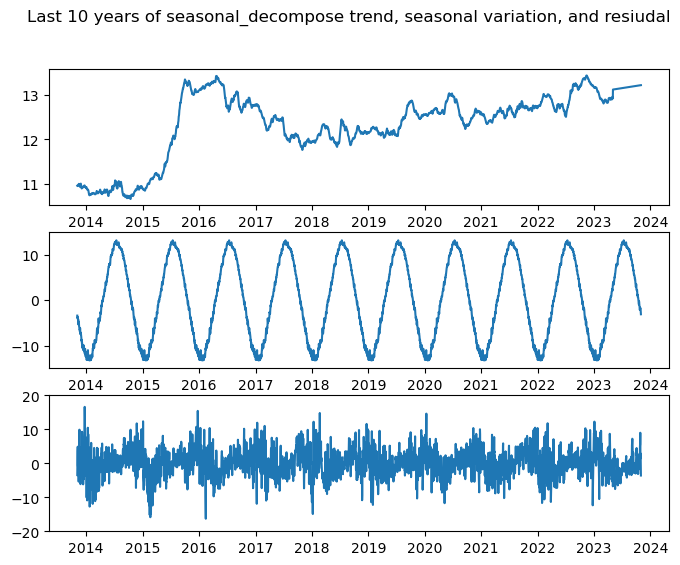

In [131]:
decompose_result = seasonal_decompose(temperatures['T'], model='additive', period=int(365), extrapolate_trend='freq')

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

years_examined = 365*10
fig, axs = plt.subplots(3, figsize=(8,6))
fig.suptitle('Last 10 years of seasonal_decompose trend, seasonal variation, and resiudal')
axs[0].plot(trend[-years_examined:])
axs[1].plot(seasonal[-years_examined:])
axs[1].set_ylim([-15,15])
axs[2].plot(residual[-years_examined:])
axs[2].set_ylim([-20,20])
plt.show()

### Linear and seasonal components

Infer from plots: 
- $T_{linear} = a + bt$
- $ T_{seasonal} = \alpha \sin(\omega t + \theta)$ (simplest)

In [132]:
temp_t = temperatures['T'].copy(deep=True)
temp_t = temp_t.to_frame()
temp_t['day'] = temp_t.index.dayofyear
temp_t['month'] = temp_t.index.month
temp_t

,T,day,month
Date,,,
1950-01-01,0.981833,1,1
1950-01-02,4.679750,2,1
1950-01-03,10.221416,3,1
1950-01-04,14.419333,4,1
1950-01-05,12.688085,5,1
...,...,...,...
2023-10-28,20.346666,301,10
2023-10-29,12.846667,302,10
2023-10-30,14.090415,303,10


In [133]:
def model(x, a,b,a1,b1):
    omega = 2*np.pi/365.25 #365.25
#     theta = np.arctan(a1/b1)
    theta=math.atan2(a1,b1)
    alpha = np.sqrt( a1**2 + b1**2)
#     print('Parameters:\n     a {0:0.3}\n     b {1:0.3}\n alpha {2:0.3}\n theta {3:0.3}'.format(a,b,alpha,theta))
    y_pred = a + b*x + alpha*np.sin(omega*x + theta)
    return y_pred

Parameters:
     a 10.9
     b 4.99e-05
 alpha 12.6
 theta -1.98


<AxesSubplot:xlabel='Date'>

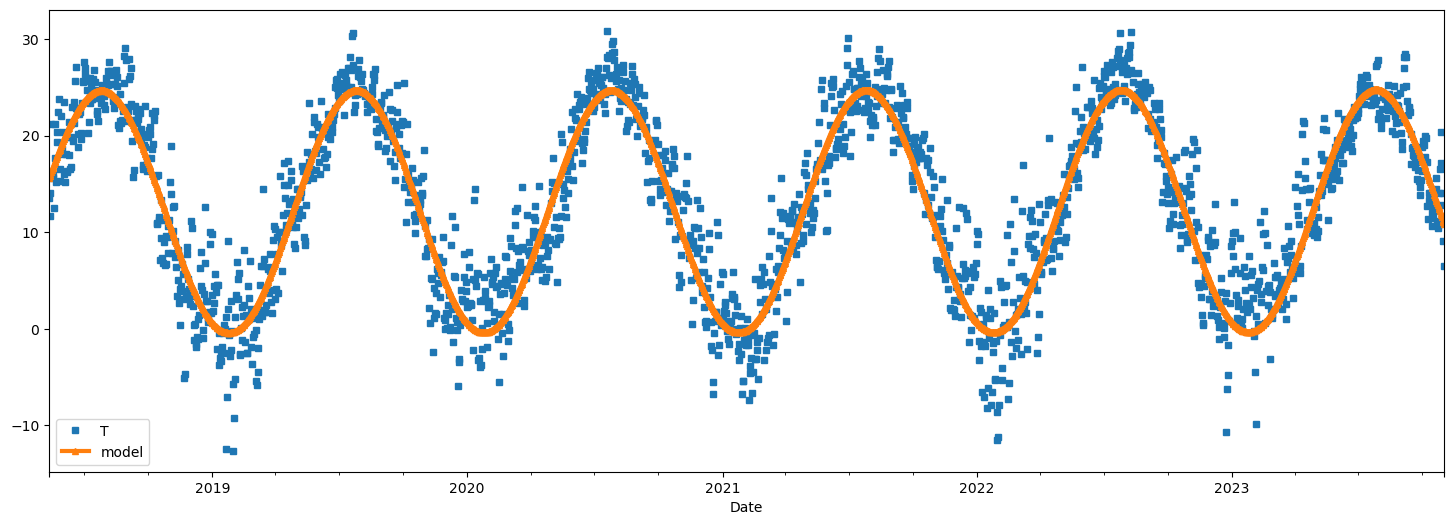

In [134]:
# Change index to integers
temp_t.index=temp_t.index.map(dt.datetime.toordinal)
first_ord = temp_t.index[0]

params_all, cov = curve_fit(model, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method='lm')

temp_t['model'] = model(temp_t.index-first_ord, *params_all)

# Change index back to dates
temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

a,b,a1,b1=params_all
omega = 2*np.pi/365.25 #365.25
theta=math.atan2(a1,b1)
alpha = np.sqrt( a1**2 + b1**2)
print('Parameters:\n     a {0:0.3}\n     b {1:0.3}\n alpha {2:0.3}\n theta {3:0.3}'.format(a,b,alpha,theta))

temp_t[['T','model']][-2000:].plot(figsize=(18,6), style=['s','^-','k-'] , markersize=4, linewidth=3 )

### Resulting Model

$\bar{T_t} = a + bt + \alpha \sin(\omega t + \theta) = 10.9 + (4.99\times10^{-5})t + 12.6 \sin\left(\left(\frac{2\pi}{365.25}\right)t  -1.98\right),$

where the starting date (chosen above, 1950-01-01) corresponds with the first ordinal number 0.

### Mean-reversion

- Standard model for temperature: mean reverting Ornstein-Uhlenbeck (OU) process (because of its cyclical nature) with rate of mean reversion $\kappa$
- Accounting for partial autocorrelation: add at least one lag term, i.e. autoregressive model AR(1)
- Ensures the expectation is equal to the longrun average of the daily temperature 

$\mathrm{d}T_t = \left[\frac{\mathrm{d}\bar{T_t}}{\mathrm{d}t} + \kappa(\bar{T_t} - T_t)\right]\mathrm{d}t + \sigma_t \mathrm{d}W_t$

In [135]:
temp_t['res'] = temp_t['T']-temp_t['model']
residuals = temp_t['res']
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

model = AutoReg(residuals, lags=1, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
# res.index = res.index.to_timestamp()
print(model_fit.summary())
gamma = coef[0]
kappa = 1 - gamma

print("Rate of mean reversion kappa is estimated as: {:0.3}".format(kappa))

                            AutoReg Model Results                             
Dep. Variable:                    res   No. Observations:                26968
Model:                     AutoReg(1)   Log Likelihood              -65877.205
Method:               Conditional MLE   S.D. of innovations              2.784
Date:                Tue, 30 Jul 2024   AIC                         131758.409
Time:                        23:27:29   BIC                         131774.814
Sample:                    01-02-1950   HQIC                        131763.700
                         - 11-01-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res.L1         0.6753      0.004    150.339      0.000       0.666       0.684
                                    Roots                                    
                  Real          Imaginary           M

/var/folders/7s/0ct0t68d3nndpfvmjbz549z00000gn/T/ipykernel_87553/967489062.py:5: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  model = AutoReg(residuals, lags=1, old_names=True,trend='n')


### Modelling volatility

- Dynamic volatility estimator: based on the the quadratic variation $\sigma_t^2$ of the temperature process, i.e.  $\hat{\sigma}^2_t = \frac{1}{N_t} \sum^{N-1}_{i=0} (T_{i+1} - T_i)^2 $ (calculated for each day of the year, 1, ..., 366)
- Model of the volatility: different approaches so choose simplest viable one, i.e. a piecewise constant function for each month

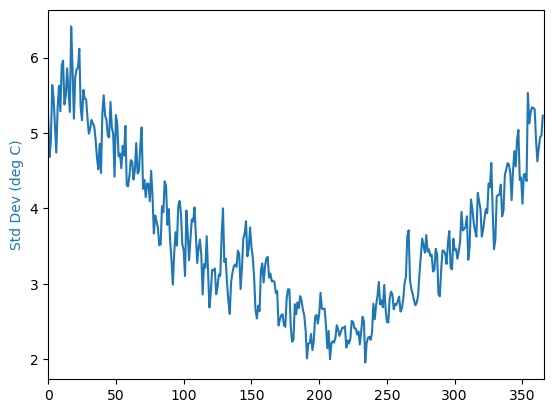

In [136]:
temp_vol = temperatures['T'].copy(deep=True)
temp_vol = temp_vol.to_frame()
temp_vol['day'] = temp_vol.index.dayofyear
temp_vol['month'] = temp_vol.index.month

# Calculate dynamic volatility of temperatures based on the day of the year (1, ..., 366) via quadratic variation
vol = temp_vol.groupby(['day'])['T'].agg(['mean','std'])
days = np.array(vol['std'].index)
T_std = np.array(vol['std'].values)

plt.plot(T_std,color='tab:blue')
plt.ylabel('Std Dev (deg C)',color='tab:blue')
plt.xlim(0,366) 
plt.show()

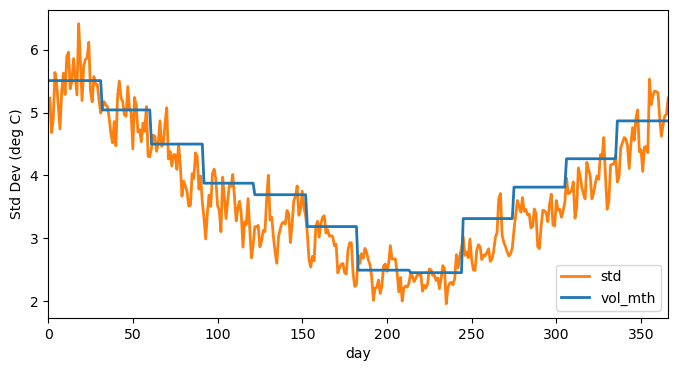

In [137]:
# Volatility model as piecewise constant functions over each month
vol_days = temp_t.groupby(['day'])['T'].agg(['mean','std'])
vol_mths = temp_t.groupby(['month'])['T'].agg(['mean','std'])
vol_days["days"] = vol_days.index
def change_month(row):
    date = dt.datetime(2016, 1, 1) + dt.timedelta(row.days - 1)
    return vol_mths.loc[date.month,'std']
vol_days['vol_mth'] = vol_days.apply(change_month, axis=1)
vol_days[['std', 'vol_mth']].plot(color=['tab:orange','tab:blue'],linewidth=2, figsize=(8,4))
plt.ylabel('Std Dev (deg C)')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()

## Valuation

### Monte Carlo simulations of temperature

- Euler scheme of approximation: $T_{i+1} = T_{i} + \bar{T}'_{i} + \kappa(\bar{T}_{i} - T_{i}) + \sigma_i z_i$

Requires first derivative for step approximation: $\bar{T'_t} = (4.99*10^{-5}) + 12.6 \left(\frac{2\pi}{365.25}\right) \cos\left(\left(\frac{2\pi}{365.25}\right)t  -1.98\right)$

### Monte Carlo Valuation

- Implement Monte Carlo method detailed in references: calculate discounted expectation of the payoff under an assumed risk-neutral probability measure

In [138]:
def T_model(x, a, b, alpha, theta):
    omega = 2*np.pi/365.25
    T = a + b*x + alpha*np.sin(omega*x + theta)
    return T
def dT_model(x, a, b, alpha, theta):
    omega=2*np.pi/365.25
    dT =  b + alpha*omega*np.cos(omega*x + theta)
    return dT

# Spline to model volatility (not needed as using piecewise constant model)
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

def euler_step(row, kappa, M, lamb_da):
    """Function for Euler scheme approximation step in 
    modified OU dynamics for temperature simulations
    Inputs: 
    - dataframe row with columns: T, Tbar, dTbar and vol
    - kappa: rate of mean reversion
    - M: number of simulations
    Output:
    - temp: simulated next day temperatures
    """
    if row['Tbar_shift'] != np.nan:
        T_i = row['Tbar']
    else:
        T_i = row['Tbar_shift']
    T_det = T_i + row['dTbar']
    T_mrev =  kappa*(row['Tbar'] - T_i)
    sigma = row['vol']*np.random.randn(M)
    riskn = lamb_da*row['vol']
    return T_det + T_mrev + sigma - riskn

In [139]:
def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, kappa=0.325, lamb_da=0):
    """Monte Carlo simulation of temperature
    Inputs:
    - trading_dates: pandas DatetimeIndex from start to end dates
    - M: number of simulations
    - Tbar_params: parameters used for Tbar model
    - vol_model: fitted volatility model with days in year index
    - first_ord: first ordinal of fitted Tbar model
    - kappa: rate of mean reversion of OU process
    Outputs:
    - mc_temps: DataFrame of all components individual components
    - mc_sims: DataFrame of all simulated temerpature paths
    """
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(dt.datetime.toordinal)

    # Use Modified Ornstein-Uhlenbeck process with estimated parameters to simulate Tbar DAT
    Tbars = T_model(trading_date-first_ord, *Tbar_params)

    # Use derivative of modified OH process SDE to calculate change of Tbar
    dTbars = dT_model(trading_date-first_ord, *Tbar_params)

    # Create DateFrame with thi
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])

    # Create columns for day in year
    mc_temps['day'] = mc_temps.index.dayofyear

    # Apply volatility model depending on day of year
    mc_temps['vol'] = vol_model[mc_temps['day']-1]

    # Shift Tbar by one day (lagged Tbar series)
    mc_temps['Tbar_shift'] = mc_temps['Tbar'].shift(1)

    # Apply Euler Step Pandas Function
    data = mc_temps.apply(euler_step, args=[kappa, M, lamb_da], axis=1)

    # Create final DataFrame of all simulations
    mc_sims = pd.DataFrame(data=[x for x in [y for y in data.values]],
                 index=trading_dates,columns=range(1,M+1))

    return mc_temps, mc_sims

In [140]:
r=0.05 # risk-free rate
K=300 # strike price
alpha=2500 # return rate of option

start_trade='2024-10-01'
end_trade='2025-03-31'

def years_between(d1, d2):
    d1 = dt.datetime.strptime(d1, "%Y-%m-%d")
    d2 = dt.datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)/365.25

today = dt.datetime.today().strftime('%Y-%m-%d')

tau = years_between(today, end_trade)
print('Start Valuation Date:', today,
      '\nEnd of Contract Date:', end_trade,
      '\nYears between Dates :', round(tau,3))

Start Valuation Date: 2024-07-30 
End of Contract Date: 2025-03-31 
Years between Dates : 0.668


### Monte Carlo Valuation

In [141]:
trading_dates = pd.date_range(start=start_trade, end=end_trade, freq='D')
no_sims = 10000

# Use simpler volatility model, i.e. piecewise constant functions
# vol_model = spline(5, days, T_std)
vol_model = vol_days['vol_mth'].to_numpy()
Tbar_params = list(params_all) # from model fit

def temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, opt='c'):
    "Evaluates the price of a temperature call option"
    mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, no_sims)
    N, M = np.shape(mc_sims)
    mc_arr = mc_sims.values
    DD = np.sum(np.maximum(18-mc_arr,0), axis=0)
    if opt == 'c':
        CT = alpha*np.maximum(DD-K,0)
    else:
        CT = alpha*np.maximum(K-DD,0)
    C0 = np.exp(-r*tau)*np.sum(CT)/M
    sigma = np.sqrt( np.sum( (np.exp(-r*tau)*CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    return C0, SE

# first_ord still defined above
call = np.round(temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, 'c'),2)
put = np.round(temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, 'p'),2)
print('Strike Price: {0}'.format(K))
print('Call Price: {0} +/- {1} (2se)'.format(call[0], call[1]*2))
print('Put Price : {0} +/- {1} (2se)'.format(put[0], put[1]*2))


Strike Price: 300
Call Price: 4965022.72 +/- 3047.54 (2se)
Put Price : 0.0 +/- 0.0 (2se)


In [142]:
# Testing different strike prices
strikes = np.arange(2000,3000,50)
data = np.zeros(shape=(len(strikes),2))
for i, strike in enumerate(strikes):
    data[i,0] = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, 'c')[0]
    data[i,1] = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, 'p')[0]



Start Valuation Date: 2024-07-30 
Start of Contract Date: 2024-10-01 
End of Contract Date: 2025-03-31


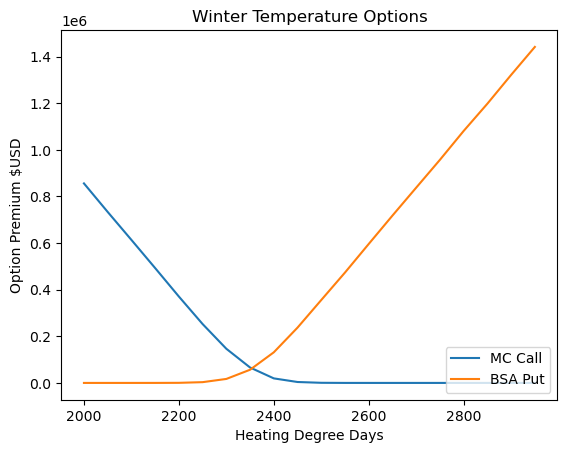

In [143]:
df = pd.DataFrame({'MC Call': data[:, 0], 'BSA Put': data[:, 1]})
df.index = strikes

print('Start Valuation Date:', today,
      '\nStart of Contract Date:', start_trade,
      '\nEnd of Contract Date:', end_trade)

plt.plot(df)
plt.title('Winter Temperature Options')
plt.ylabel('Option Premium $USD')
plt.xlabel('Heating Degree Days')
plt.legend(df.columns, loc=4)
plt.show()